# Result Table Generation

## Imports

In [1]:
import re
import os
import json
import wandb
import pathlib
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

In [2]:
from evaluation.apply_evaluation import fetch_and_report_wandb

## Settings

In [3]:
# login to wandb
# wandb.login()

In [4]:
%matplotlib inline

In [5]:
def simplify_name(name: str) -> str:
    # map each base to one of the requested tick labels
    if "EQ"   in name: return "MIX-EQ"
    if "PRE"  in name: return "MIX-PRE"
    if "INS"  in name: return "MIX-INS"
    if "lmsys" in name: return "INS"
    return "PRE"


## SAE Feature Eval

In [6]:
all_delphi_saes = [
    "smollm2-sparsify-EQ-50M-token-6_25-layers-32-expansion-64-k-layer-6",
    "smollm2-sparsify-EQ-50M-token-6_25-layers-32-expansion-64-k-layer-25",
    "smollm2-sparsify-lmsys-50M-token-6_25-layers-32-expansion-64-k-layer-6",
    "smollm2-sparsify-lmsys-50M-token-6_25-layers-32-expansion-64-k-layer-25",
    "smollm2-sparsify-INS-50M-token-6_25-layers-32-expansion-64-k-layer-6",
    "smollm2-sparsify-INS-50M-token-6_25-layers-32-expansion-64-k-layer-25",
    "smollm2-sparsify-PRE-50M-token-6_25-layers-32-expansion-64-k-layer-6",
    "smollm2-sparsify-PRE-50M-token-6_25-layers-32-expansion-64-k-layer-25",    
]

In [7]:
all_epx_data = []

all_delphi_stats_paths = [
    pathlib.Path(f"./evaluation/results/EXP-{sae_name}/explanations/")
    for sae_name in all_delphi_saes
]

all_delphi_stats_paths.append(pathlib.Path("./evaluation/delphi-tests-results/EXP-sae-SmolLM2-135M-64x/explanations"))
all_delphi_saes.append("sae-SmolLM2-135M-64x-layer-6")

latent_pattern = re.compile(r"_latent(\d+)$")

for idx, delphi_stats_path in enumerate(all_delphi_stats_paths):
    if not delphi_stats_path.is_dir():
        raise FileNotFoundError(f"directory not found: {delphi_stats_path}")

    for txt_file in delphi_stats_path.glob("*.txt"):
        try:
            # read entire file as text
            content = txt_file.read_text(encoding="utf-8")
            # extract latent index
            m = latent_pattern.search(txt_file.stem)
            latent_idx = int(m.group(1)) if m else None
            all_epx_data.append({
                "filename": txt_file.name,
                "latent": latent_idx,
                "content": content,
                "sae": all_delphi_saes[idx]
            })
        except Exception as e:
            # catch any I/O or parsing errors
            print(f"error processing '{txt_file.name}': {e}")
    
    print(f"successfully loaded data from {len(all_epx_data)} txt files.")


successfully loaded data from 954 txt files.
successfully loaded data from 1812 txt files.
successfully loaded data from 2761 txt files.
successfully loaded data from 3602 txt files.
successfully loaded data from 4545 txt files.
successfully loaded data from 5389 txt files.
successfully loaded data from 6335 txt files.
successfully loaded data from 7168 txt files.
successfully loaded data from 7564 txt files.


In [8]:
# refusal-related substrings to look for
refusal_keywords = [
    "refuse", "refusal", "deny", "denial", "reject", "decline",
    "cannot", "can't", "won't", "wouldn't", "don't", "didn't", "not",
    "opt out", "opt-out", "opted out", "abstain", "abstained",
    "forbid", "forbidden", "disallow", "prohibit", "prohibited",
    "objection", "oppose", "opposed", "withhold", # remove "object", --> too many false pos
    "no way", "no more"
]


# compile a regex matching any keyword as a whole word (case-insensitive)
sorted_kws = sorted(refusal_keywords, key=len, reverse=True)
keyword_re = re.compile(
    r"\b(" + "|".join(re.escape(kw) for kw in sorted_kws) + r")\b",
    flags=re.IGNORECASE
)

def find_refusal_features(data, keyword_re=keyword_re):
    """
    return all entries whose 'content' matches any refusal keyword.
    """
    return len(list(filter(
        lambda x: bool(keyword_re.search(x)),
        data
    )))

In [9]:
exp_df = pd.DataFrame(all_epx_data)
exp_df

,filename,latent,content,sae
0,layers.6_latent795.txt,795,"""Verbs and nouns related to taking or acquirin...",smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...
1,layers.6_latent645.txt,645,"""The token \""conf\"" is often associated with w...",smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...
2,layers.6_latent617.txt,617,"""Adverbs and nouns indicating continuation or ...",smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...
3,layers.6_latent163.txt,163,"""Tokens representing numbers, often used for e...",smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...
4,layers.6_latent922.txt,922,"""The verb \""pick\"" in various forms, often use...",smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...
...,...,...,...,...
7559,layers.24.mlp_latent702.txt,702,"""The word \""along\"" is used to indicate moveme...",sae-SmolLM2-135M-64x-layer-6
7560,layers.24.mlp_latent753.txt,753,"""Common nouns and words that are part of forma...",sae-SmolLM2-135M-64x-layer-6
7561,layers.24.mlp_latent202.txt,202,"""Nouns representing categories, classification...",sae-SmolLM2-135M-64x-layer-6
7562,layers.24.mlp_latent842.txt,842,"""Verbs that convey the idea of giving, offerin...",sae-SmolLM2-135M-64x-layer-6


In [10]:
exp_df["is_refusal_related"] = exp_df.content.apply(lambda x: True if find_refusal_features([x]) > 0 else False)
exp_df = exp_df[~exp_df["content"].str.contains("Explanation could not be parsed", na=False)]
exp_df["is_refusal_related"].sum()

93

In [11]:
# extract trailing layer number as int (will be NaN for those without '-layer-<n>')
exp_df['layer'] = (
    exp_df['sae']
    .str.extract(r'-layer-(\d+)$', expand=False)
    .astype('Int64')  # pandas nullable integer
)

# strip off '-layer-<n>' to get the shared base name
exp_df['base_name'] = exp_df['sae'].str.replace(r'-layer-\d+$', '', regex=True)

/tmp/ipykernel_2780171/474652846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df['layer'] = (
/tmp/ipykernel_2780171/474652846.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df['base_name'] = exp_df['sae'].str.replace(r'-layer-\d+$', '', regex=True)


In [12]:
exp_df.query("is_refusal_related==True and sae=='smollm2-sparsify-PRE-50M-token-6_25-layers-32-expansion-64-k-layer-25'").to_csv("results/saes/features/add_delphi_results.csv", index=False)

In [13]:
exp_df.query("is_refusal_related==True").shape

(93, 7)

/tmp/ipykernel_2780171/3718453.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


  -> Plot saved to 'results/visualizations/refusal_by_sae_with_avg_line.png'


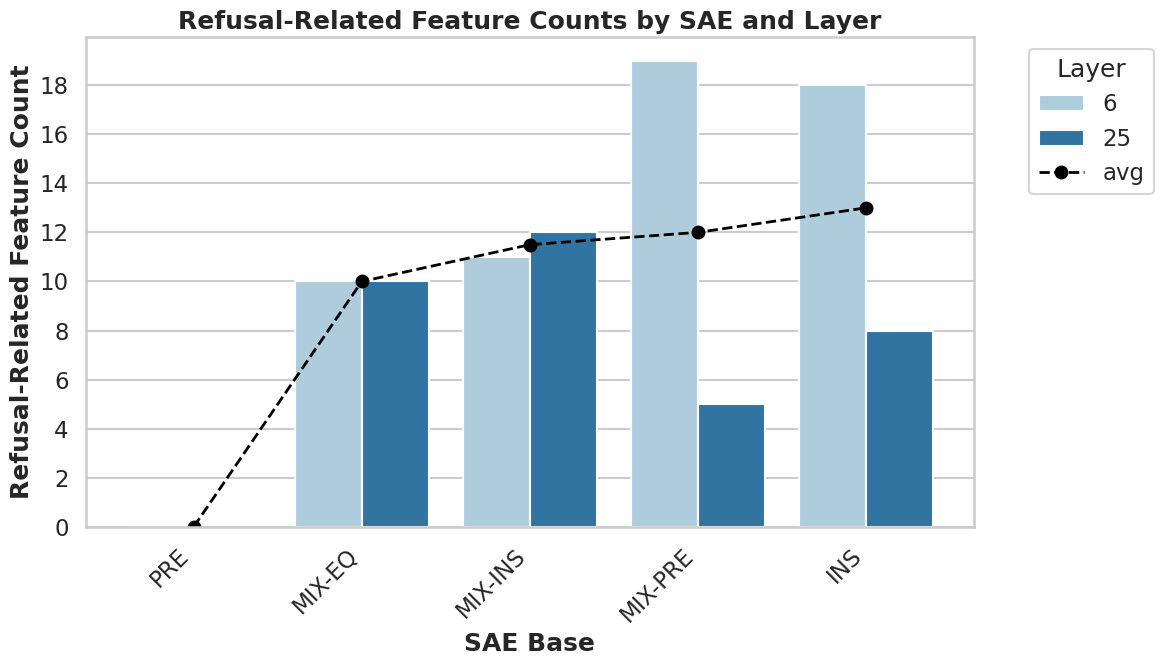

In [14]:
def visualize_refusal_by_sae(df: pd.DataFrame, results_path: str = "results/visualizations/"):
    if df.empty:
        print("DataFrame is empty. Skipping visualization.")
        return

    Path(results_path).mkdir(parents=True, exist_ok=True)
    sns.set_theme(style="whitegrid", context="talk")

    df2 = df.copy()
    df2['layer'] = (
        df2['sae']
        .str.extract(r'-layer-(\d+)$', expand=False)
        .astype('Int64')
    )
    df2['base_name'] = df2['sae'].str.replace(r'-layer-\d+$', '', regex=True)

    agg = (
        df2
        .groupby(['base_name', 'layer'], as_index=False)
        ['is_refusal_related']
        .sum()
        .rename(columns={'is_refusal_related': 'refusal_count'})
    )

    bar_data = agg[agg['layer'].notna()].copy()
    mean_df = (
        bar_data
        .groupby('base_name', as_index=False)['refusal_count']
        .mean()
        .rename(columns={'refusal_count': 'avg_refusal_count'})
    )

    plt.figure(figsize=(12, 7))
    ax = sns.barplot(
        data=bar_data,
        x='base_name',
        y='refusal_count',
        hue='layer',
        palette='Paired',
    )

    x_labels = [t.get_text() for t in ax.get_xticklabels()]
    xs = range(len(x_labels))
    ys = [mean_df.loc[mean_df['base_name'] == name, 'avg_refusal_count'].iloc[0]
          for name in x_labels]
    ax.plot(xs, ys, marker='o', linestyle='--', linewidth=2, color='black', label='avg')  # avg line black

    ax.set_xlabel("SAE Base", weight='bold')
    ax.set_ylabel("Refusal-Related Feature Count", weight='bold')
    ax.set_title("Refusal-Related Feature Counts by SAE and Layer", weight='bold')

    # force y-axis to integer ticks
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax.set_xticklabels(
        [simplify_name(lbl) for lbl in x_labels],
        rotation=45,
        ha='right'
    )

    handles, labels = ax.get_legend_handles_labels()
    if 'avg' in labels:
        avg_idx = labels.index('avg')
        handles.append(handles.pop(avg_idx))
        labels.append(labels.pop(avg_idx))
    ax.legend(handles, labels, title='Layer', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    save_path = Path(results_path) / "refusal_by_sae_with_avg_line.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"  -> Plot saved to '{save_path}'")
    plt.show()
    plt.close()
    
visualize_refusal_by_sae(exp_df)

In [15]:
refusal_realted_df = exp_df.query("is_refusal_related == True")#.groupby("sae")
refusal_realted_df.to_csv("results/saes/features/delphi_results.csv", index=False)

In [16]:
refusal_realted_df

,filename,latent,content,sae,is_refusal_related,layer,base_name
44,layers.6_latent928.txt,928,"""Negation words or phrases, often used to indi...",smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...,True,6,smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...
73,layers.6_latent730.txt,730,"""Negation in text, often expressed through the...",smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...,True,6,smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...
88,layers.6_latent636.txt,636,"""Polite expressions of encouragement or warnin...",smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...,True,6,smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...
91,layers.6_latent186.txt,186,"""The word \""all\"" is often used in a negative ...",smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...,True,6,smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...
275,layers.6_latent506.txt,506,"""Auxiliary verbs, particularly \""do\"", \""does\...",smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...,True,6,smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...
...,...,...,...,...,...,...,...
6494,layers.25_latent421.txt,421,"""Adjectives describing entities that are not c...",smollm2-sparsify-PRE-50M-token-6_25-layers-32-...,True,25,smollm2-sparsify-PRE-50M-token-6_25-layers-32-...
6545,layers.25_latent843.txt,843,"""Function words and grammatical elements, incl...",smollm2-sparsify-PRE-50M-token-6_25-layers-32-...,True,25,smollm2-sparsify-PRE-50M-token-6_25-layers-32-...
6565,layers.25_latent904.txt,904,"""The presence of words \""zero\"", \""no\"", and \...",smollm2-sparsify-PRE-50M-token-6_25-layers-32-...,True,25,smollm2-sparsify-PRE-50M-token-6_25-layers-32-...
6582,layers.25_latent911.txt,911,"""The verb \""wait\"" often used in expressions o...",smollm2-sparsify-PRE-50M-token-6_25-layers-32-...,True,25,smollm2-sparsify-PRE-50M-token-6_25-layers-32-...


## Baseline

 -> Plot saved to 'results/visualizations/baseline_performance'


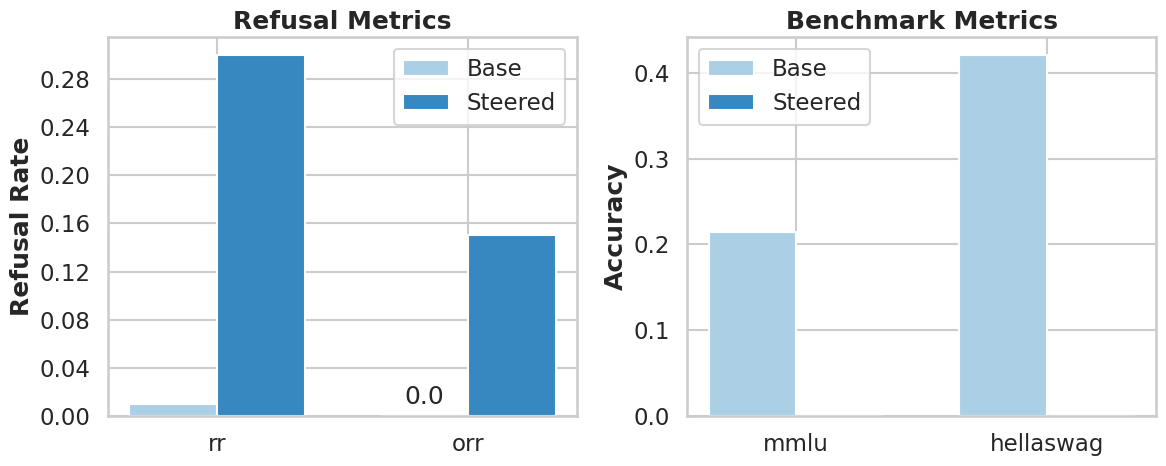

In [46]:
def plot_baseline(
    data: dict,
    results_path: str = "results/visualizations/"
):
    """
    Plots refusal and benchmark metrics for base vs steered performance
    given a dict of metric -> {'base': val, 'steered': val}.
    Splits into small multiples for refusal and benchmark metrics.
    """
    # ensure output dir
    Path(results_path).mkdir(parents=True, exist_ok=True)

    # set style
    sns.set_theme(style="whitegrid", context="talk")

    # separate metrics
    refusal_metrics = ['rr', 'orr']
    bench_metrics   = ['mmlu', 'hellaswag']

    # extract values
    base_ref      = [data[m]['base'] for m in refusal_metrics]
    steered_ref   = [data[m]['steered'] for m in refusal_metrics]
    base_bench    = [data[m]['base'] for m in bench_metrics]
    steered_bench = [data[m]['steered'] for m in bench_metrics]

    # positions
    x_ref   = np.arange(len(refusal_metrics))
    x_bench = np.arange(len(bench_metrics))
    width   = 0.35
    colors  = sns.color_palette("Blues", 2)

    # create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # refusal subplot
    ax = axes[0]
    bars1 = ax.bar(x_ref - width/2, base_ref, width, label='Base', color=colors[0])
    bars2 = ax.bar(x_ref + width/2, steered_ref, width, label='Steered', color=colors[1])
    # annotate zeros
    for bar in bars1 + bars2:
        if np.isclose(bar.get_height(), 0):
            ax.annotate('0.0',
                        xy=(bar.get_x() + bar.get_width()/2, 0),
                        xytext=(0, 5), textcoords='offset points',
                        ha='center', va='bottom')
    ax.set_xticks(x_ref)
    ax.set_xticklabels(refusal_metrics)
    ax.set_ylabel('Refusal Rate', fontweight='bold')
    ax.set_title('Refusal Metrics', fontweight='bold')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.legend()

    # benchmark subplot
    ax2 = axes[1]
    bars3 = ax2.bar(x_bench - width/2, base_bench, width, label='Base', color=colors[0])
    bars4 = ax2.bar(x_bench + width/2, steered_bench, width, label='Steered', color=colors[1])
    ax2.set_xticks(x_bench)
    ax2.set_xticklabels(bench_metrics)
    ax2.set_ylabel('Accuracy', fontweight='bold')
    ax2.set_title('Benchmark Metrics', fontweight='bold')
    ax2.legend()

    plt.tight_layout()
    save_path = Path(results_path) / "baseline_performance"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f" -> Plot saved to '{save_path}'")
    plt.show()
    plt.close()

baseline_data = dict()
with open("./results/baseline.json", "r") as f:
    baseline_data = json.load(f)    

plot_baseline(baseline_data["HuggingFaceTB_SmolLM2-135M"])

## SAE-Train Visualisations

In [17]:
from evaluation.visualise_sae_metrics import load_sae_results, visualize_sae_results_grouped, plot_data_dependence_heatmap

RESULTS_DIRECTORY = "results/saes/"

results_df = load_sae_results(RESULTS_DIRECTORY)
# if not results_df.empty:
    # visualize_sae_results_grouped(results_df)

Found 192 result files. Loading...
Data loaded and processed successfully.


In [18]:
results_df.sort_values(by="mse", ascending=True)

,explained_variance,fraction_var_unexplained,mse,cosine_similarity,activation_sparsity_l0,weight_sparsity,dead_features_pct,dead_features_count,total_latents,eval_dataset,model,layer,sae_train_dataset,sae_token_size,sae_expansion_factor,sae_k_value,sae_checkpoint_name,sae_token_size_mil
72,0.943233,0.056767,1.024234,0.970973,0.003472,0.000029,0.045627,841,18432,GAIR/lima,HuggingFaceTB/SmolLM2-135M,6,EQ,50M,32,64,smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...,50.0
23,0.942723,0.057277,1.033431,0.970637,0.003472,0.000028,0.050130,924,18432,GAIR/lima,HuggingFaceTB/SmolLM2-135M,6,INS,50M,32,64,smollm2-sparsify-INS-50M-token-6_25-layers-32-...,50.0
122,0.942610,0.057390,1.035462,0.970636,0.003472,0.000027,0.051866,956,18432,GAIR/lima,HuggingFaceTB/SmolLM2-135M,6,PRE,50M,32,64,smollm2-sparsify-PRE-50M-token-6_25-layers-32-...,50.0
124,0.939191,0.060809,1.097150,0.968727,0.003472,0.000028,0.047743,880,18432,GAIR/lima,HuggingFaceTB/SmolLM2-135M,6,lmsys,50M,32,64,smollm2-sparsify-lmsys-50M-token-6_25-layers-3...,50.0
53,0.942081,0.057919,1.137375,0.968388,0.003472,0.000027,0.067925,1252,18432,datablations/c4-filter-small,HuggingFaceTB/SmolLM2-135M,6,PRE,50M,32,64,smollm2-sparsify-PRE-50M-token-6_25-layers-32-...,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,0.953430,0.046570,162.295610,0.840606,0.013889,0.000200,0.139106,641,4608,datablations/c4-filter-small,HuggingFaceTB/SmolLM2-135M,25,EQ,419M,8,64,smollm2-sparsify-EQ-419M-token-6_25-layers-8-e...,419.0
142,0.952399,0.047601,165.888999,0.821945,0.013889,0.000166,0.126736,584,4608,datablations/c4-filter-small,HuggingFaceTB/SmolLM2-135M,25,lmsys,419M,8,64,smollm2-sparsify-lmsys-419M-token-6_25-layers-...,419.0
150,0.948181,0.051819,180.588454,0.940902,0.003472,0.000046,0.209852,3868,18432,datablations/c4-filter-small,HuggingFaceTB/SmolLM2-135M,25,INS,419M,32,64,smollm2-sparsify-INS-419M-token-6_25-layers-32...,419.0
9,0.908226,0.091774,273.553894,0.844701,0.013889,0.000149,0.128689,593,4608,GAIR/lima,HuggingFaceTB/SmolLM2-135M,25,PRE,419M,8,64,smollm2-sparsify-PRE-419M-token-6_25-layers-8-...,419.0


**Pick best SAEs for every layer:**

In [19]:
idx = (
    results_df
    .groupby(["layer", "sae_train_dataset"])["explained_variance"]
    .idxmax()
)
best_df = results_df.loc[idx].reset_index(drop=True)
best_saes_checkpoint_names = best_df["sae_checkpoint_name"].to_list()

In [20]:
best_saes_checkpoint_names

['smollm2-sparsify-EQ-50M-token-6_25-layers-32-expansion-64-k/layers.6',
 'smollm2-sparsify-INS-50M-token-6_25-layers-32-expansion-64-k/layers.6',
 'smollm2-sparsify-PRE-50M-token-6_25-layers-32-expansion-64-k/layers.6',
 'smollm2-sparsify-lmsys-50M-token-6_25-layers-32-expansion-64-k/layers.6',
 'smollm2-sparsify-EQ-50M-token-6_25-layers-32-expansion-64-k/layers.25',
 'smollm2-sparsify-INS-50M-token-6_25-layers-32-expansion-64-k/layers.25',
 'smollm2-sparsify-PRE-50M-token-6_25-layers-32-expansion-64-k/layers.25',
 'smollm2-sparsify-lmsys-50M-token-6_25-layers-32-expansion-64-k/layers.25']

In [21]:
best_df

,explained_variance,fraction_var_unexplained,mse,cosine_similarity,activation_sparsity_l0,weight_sparsity,dead_features_pct,dead_features_count,total_latents,eval_dataset,model,layer,sae_train_dataset,sae_token_size,sae_expansion_factor,sae_k_value,sae_checkpoint_name,sae_token_size_mil
0,0.943233,0.056767,1.024234,0.970973,0.003472,0.000029,0.045627,841,18432,GAIR/lima,HuggingFaceTB/SmolLM2-135M,6,EQ,50M,32,64,smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...,50.0
1,0.942723,0.057277,1.033431,0.970637,0.003472,0.000028,0.050130,924,18432,GAIR/lima,HuggingFaceTB/SmolLM2-135M,6,INS,50M,32,64,smollm2-sparsify-INS-50M-token-6_25-layers-32-...,50.0
2,0.942610,0.057390,1.035462,0.970636,0.003472,0.000027,0.051866,956,18432,GAIR/lima,HuggingFaceTB/SmolLM2-135M,6,PRE,50M,32,64,smollm2-sparsify-PRE-50M-token-6_25-layers-32-...,50.0
3,0.939191,0.060809,1.097150,0.968727,0.003472,0.000028,0.047743,880,18432,GAIR/lima,HuggingFaceTB/SmolLM2-135M,6,lmsys,50M,32,64,smollm2-sparsify-lmsys-50M-token-6_25-layers-3...,50.0
4,0.987426,0.012574,43.821970,0.964894,0.003472,0.000026,0.176704,3257,18432,datablations/c4-filter-small,HuggingFaceTB/SmolLM2-135M,25,EQ,50M,32,64,smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...,50.0
5,0.988271,0.011729,40.874484,0.964429,0.003472,0.000024,0.180881,3334,18432,datablations/c4-filter-small,HuggingFaceTB/SmolLM2-135M,25,INS,50M,32,64,smollm2-sparsify-INS-50M-token-6_25-layers-32-...,50.0
6,0.989657,0.010343,36.044102,0.964745,0.003472,0.000026,0.182237,3359,18432,datablations/c4-filter-small,HuggingFaceTB/SmolLM2-135M,25,PRE,50M,32,64,smollm2-sparsify-PRE-50M-token-6_25-layers-32-...,50.0
7,0.987441,0.012559,43.769764,0.961539,0.003472,0.000025,0.165527,3051,18432,datablations/c4-filter-small,HuggingFaceTB/SmolLM2-135M,25,lmsys,50M,32,64,smollm2-sparsify-lmsys-50M-token-6_25-layers-3...,50.0


In [22]:
results_df.to_csv("results/saes/aggregations/saes.csv", index=False)

In [23]:
df_summary = results_df.groupby(["sae_train_dataset", "sae_expansion_factor", "eval_dataset"]).agg({
    "explained_variance": "mean",
    "dead_features_pct": "mean",
    "activation_sparsity_l0": "mean"
}).reset_index()

--- Generating plot for explained_variance ---
Plot saved to results/visualizations/avg_explained_variance_across_ds.png


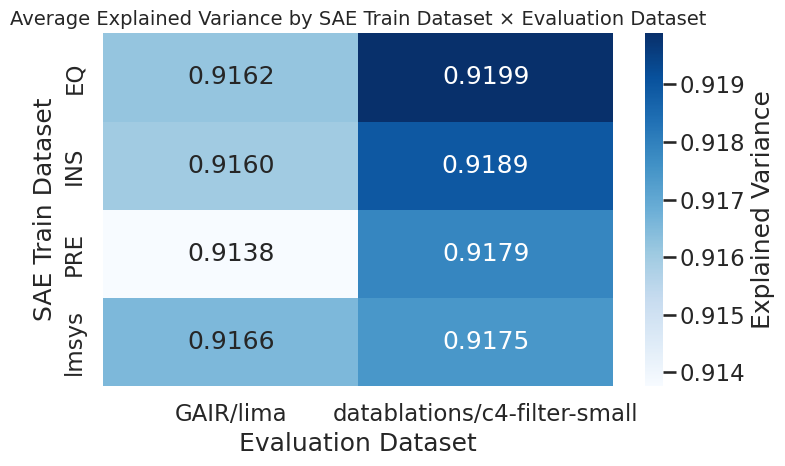

--- Generating plot for mse ---
Plot saved to results/visualizations/avg_mse_across_ds.png


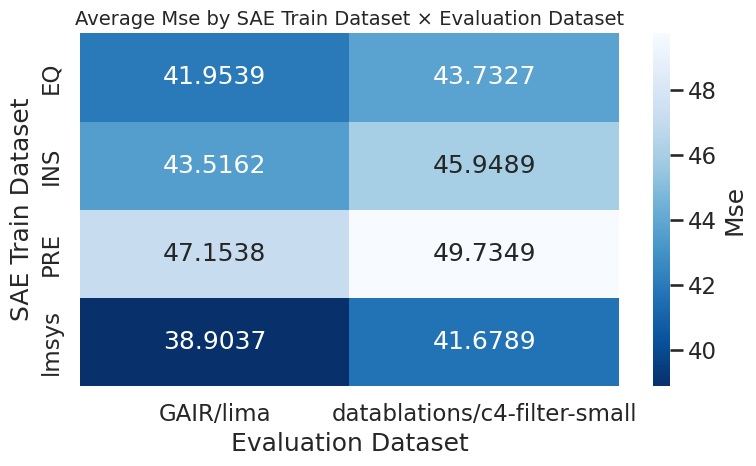

--- Generating plot for cosine_similarity ---
Plot saved to results/visualizations/avg_cosine_similarity_across_ds.png


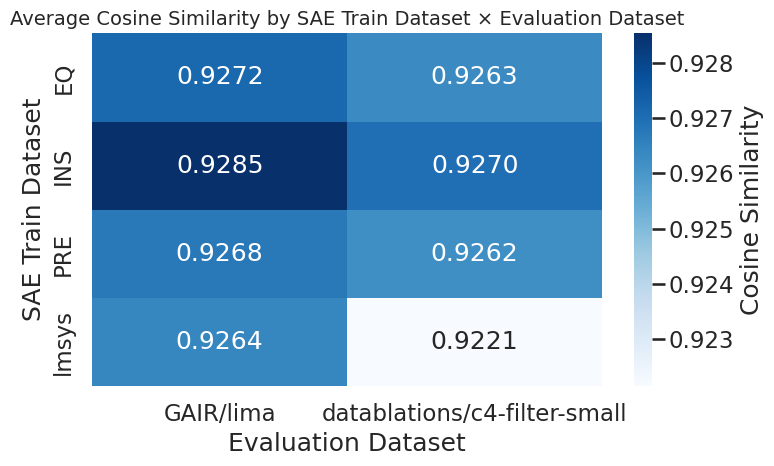

In [24]:
metric_list = [
    "explained_variance",
    # "fraction_var_unexplained",
    "mse",
    "cosine_similarity",
    # "activation_sparsity_l0",
    # "weight_sparsity",
    # "dead_features_pct"
]

for metric in metric_list:
    print(f"--- Generating plot for {metric} ---")
    
    # Use a different colormap for metrics where "higher is worse" (like MSE)
    color_map = "Blues_r" if metric in ["mse", "fraction_var_unexplained"] else "Blues"
    
    # Use a different format for percentages
    num_format = ".2f" if "pct" in metric else ".4f"

    plot_data_dependence_heatmap(
        df=results_df,
        metric_name=metric,
        # results_path=results_path,
        cmap=color_map,
        fmt=num_format
    )

## Dataset-visuals

/tmp/ipykernel_2780171/1866428773.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_ordered.index, y=df_ordered[metric], ax=ax, palette="Blues_d")
/tmp/ipykernel_2780171/1866428773.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_ordered.index, y=df_ordered[metric], ax=ax, palette="Blues_d")
/tmp/ipykernel_2780171/1866428773.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_ordered.index, y=df_ordered[metric], ax=ax, palette="Blues_d")
/tmp/ipykernel_2780171/1866428773.py:29: FutureWarning: 

Passing `palette` withou

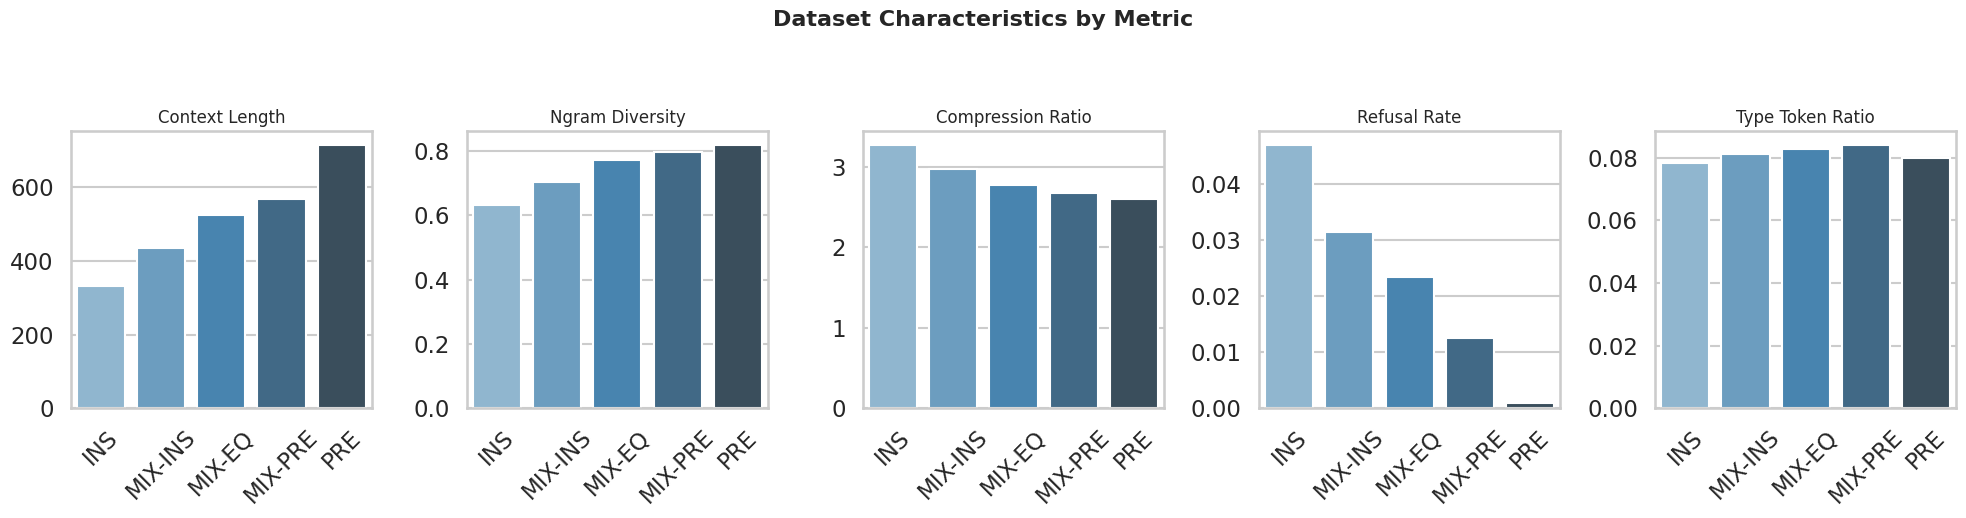

In [25]:
sns.set_theme(style="whitegrid", context="talk")

results_dir = "results/dataset_chars"
data = []
for fname in os.listdir(results_dir):
    if fname.endswith("_metrics.json"):
        with open(os.path.join(results_dir, fname), "r") as f:
            d = json.load(f)
        d["dataset"] = fname.replace("_metrics.json", "")
        data.append(d)

df = pd.DataFrame(data)
df.set_index("dataset", inplace=True)

ordered_datasets = ["INS", "MIX-INS", "MIX-EQ", "MIX-PRE", "PRE"]

# Filter and reorder the dataframe accordingly
df_filtered = df.loc[df.index.intersection(ordered_datasets)]
df_ordered = df_filtered.reindex(ordered_datasets)

# Plot each metric separately using the ordered dataset list
metrics = ["context_length", "ngram_diversity", "compression_ratio", "refusal_rate", "type_token_ratio"]
n_metrics = len(metrics)

fig, axes = plt.subplots(nrows=1, ncols=n_metrics, figsize=(4 * n_metrics, 5), sharex=False)

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x=df_ordered.index, y=df_ordered[metric], ax=ax, palette="Blues_d")
    ax.set_title(metric.replace("_", " ").title(), fontsize=12)
    ax.set_ylabel("")  # suppress for compactness
    ax.set_xlabel("")

    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.suptitle("Dataset Characteristics by Metric", fontsize=16, y=1.05, weight="bold")
plt.tight_layout()
plt.savefig("./results/visualizations/dataset_chars.png", dpi=150, bbox_inches='tight')
plt.show()

## SAE Performance

In [26]:
refusal_path = Path("./results/perfomance/refusal/")
refusal_files = list(refusal_path.glob("*.json"))

# parse each file into a dict with filename stem as an identifier
refusal_data = []
for file in refusal_files:
    with open(file, "r") as f:
        data = json.load(f)
        data["config_name"] = file.stem
        refusal_data.append(data)

df1 = pd.DataFrame(refusal_data)

# 2. read from ./results/perfomance/downstream/ using the filename stems
downstream_path = Path("./results/perfomance/downstream/")
downstream_data = []

for config_name in df1["config_name"]:
    subdir = downstream_path / config_name
    if not subdir.exists() or not subdir.is_dir():
        continue
    for inner_dir in subdir.iterdir():
        if inner_dir.is_dir():
            json_files = list(inner_dir.glob("*.json"))
            if not json_files:
                continue
            # pick the most recent file
            latest_file = max(json_files, key=lambda x: x.stat().st_mtime)
            with open(latest_file, "r") as f:
                result_json = json.load(f)
                hellaswag_acc = result_json.get("results", {}).get("hellaswag", {}).get("acc,none")
                mmlu_acc = result_json.get("results", {}).get("mmlu", {}).get("acc,none")
                downstream_data.append({
                    "config_name": config_name,
                    "hellaswag_acc": hellaswag_acc,
                    "mmlu_acc": mmlu_acc
                })
            break  # only read one matching dir

df2 = pd.DataFrame(downstream_data)

# 3. merge df1 and df2 on config_name
merged_df = pd.merge(df1, df2, on="config_name", how="inner")

In [27]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   steer_path             8 non-null      object 
 1   feature_indices        8 non-null      object 
 2   steering_coefficients  8 non-null      object 
 3   rr                     9 non-null      float64
 4   rr_2                   6 non-null      float64
 5   orr                    9 non-null      float64
 6   orr_2                  6 non-null      float64
 7   config_name            9 non-null      object 
 8   steer_cfg              1 non-null      object 
 9   cosine_sim             2 non-null      float64
 10  rr2                    2 non-null      float64
 11  orr2                   2 non-null      float64
 12  hellaswag_acc          9 non-null      float64
 13  mmlu_acc               9 non-null      float64
dtypes: float64(9), object(5)
memory usage: 1.1+ KB


In [28]:
def extract_layer(name: str) -> int:
    match = re.search(r'layers\.(\d+)', name)
    if match:
        try:
            return int(match.group(1))
        except ValueError:
            return 6
    return 6

# augment merged_df
merged_df["ds_name"] = merged_df["config_name"].apply(simplify_name)
merged_df["layer"] = merged_df["config_name"].apply(extract_layer)

In [29]:
merged_df

,steer_path,feature_indices,steering_coefficients,rr,rr_2,orr,orr_2,config_name,steer_cfg,cosine_sim,rr2,orr2,hellaswag_acc,mmlu_acc,ds_name,layer
0,/home/tilman.kerl/mech-interp/src/steer_config...,"[997, 309, 506, 125, 667, 920, 180, 846]","[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]",0.00,0.00,0.00,0.00,smollm2-sparsify-lmsys-50M-token-6_25-layers-3...,NaN,NaN,NaN,NaN,0.320852,0.229454,INS,6
1,NaN,NaN,NaN,0.00,NaN,0.00,NaN,sae-SmolLM2-135M-64x,"{'layers.24.mlp': {'action': 'add', 'sparse_mo...",NaN,NaN,NaN,0.354411,0.236647,PRE,6
2,/home/tilman.kerl/mech-interp/src/steer_config...,"[928, 730, 186, 506, 510, 703, 180]","[14.0, 17.0, 14.0, 14.0, 17.0, 14.0, 14.0]",0.00,NaN,0.00,NaN,smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...,NaN,1.0,0.01,0.0,0.335889,0.234440,MIX-EQ,6
3,/home/tilman.kerl/mech-interp/src/steer_config...,"[198, 506, 752, 703, 978]","[16.0, 15.0, 15.0, 15.0, 16.0]",0.02,0.01,0.02,0.00,smollm2-sparsify-INS-50M-token-6_25-layers-32-...,NaN,NaN,NaN,NaN,0.336786,0.249964,MIX-INS,6
4,/home/tilman.kerl/mech-interp/src/steer_config...,"[791, 445, 320, 603]","[15.0, 15.0, 15.0, 16.0]",0.02,0.01,0.00,0.00,smollm2-sparsify-lmsys-50M-token-6_25-layers-3...,NaN,NaN,NaN,NaN,0.354411,0.242131,INS,25
5,/home/tilman.kerl/mech-interp/src/steer_config...,[421],[22.0],0.00,0.00,0.01,0.01,smollm2-sparsify-PRE-50M-token-6_25-layers-32-...,NaN,NaN,NaN,NaN,0.354411,0.239425,MIX-PRE,25
6,/home/tilman.kerl/mech-interp/src/steer_config...,"[169, 217, 2]","[15.0, 15.0, 17.0]",0.02,NaN,0.00,NaN,smollm2-sparsify-EQ-50M-token-6_25-layers-32-e...,NaN,1.0,0.00,0.0,0.355706,0.238855,MIX-EQ,25
7,/home/tilman.kerl/mech-interp/src/steer_config...,"[928, 730, 606, 376, 125, 703168]","[16.0, 15.0, 15.0, 15.0, 16.0]",0.04,0.00,0.02,0.00,smollm2-sparsify-PRE-50M-token-6_25-layers-32-...,NaN,NaN,NaN,NaN,0.331508,0.233015,MIX-PRE,6
8,/home/tilman.kerl/mech-interp/src/steer_config...,"[801, 76]","[17.0, 14.0]",0.00,0.00,0.00,0.00,smollm2-sparsify-INS-50M-token-6_25-layers-32-...,NaN,NaN,NaN,NaN,0.354710,0.240991,MIX-INS,25


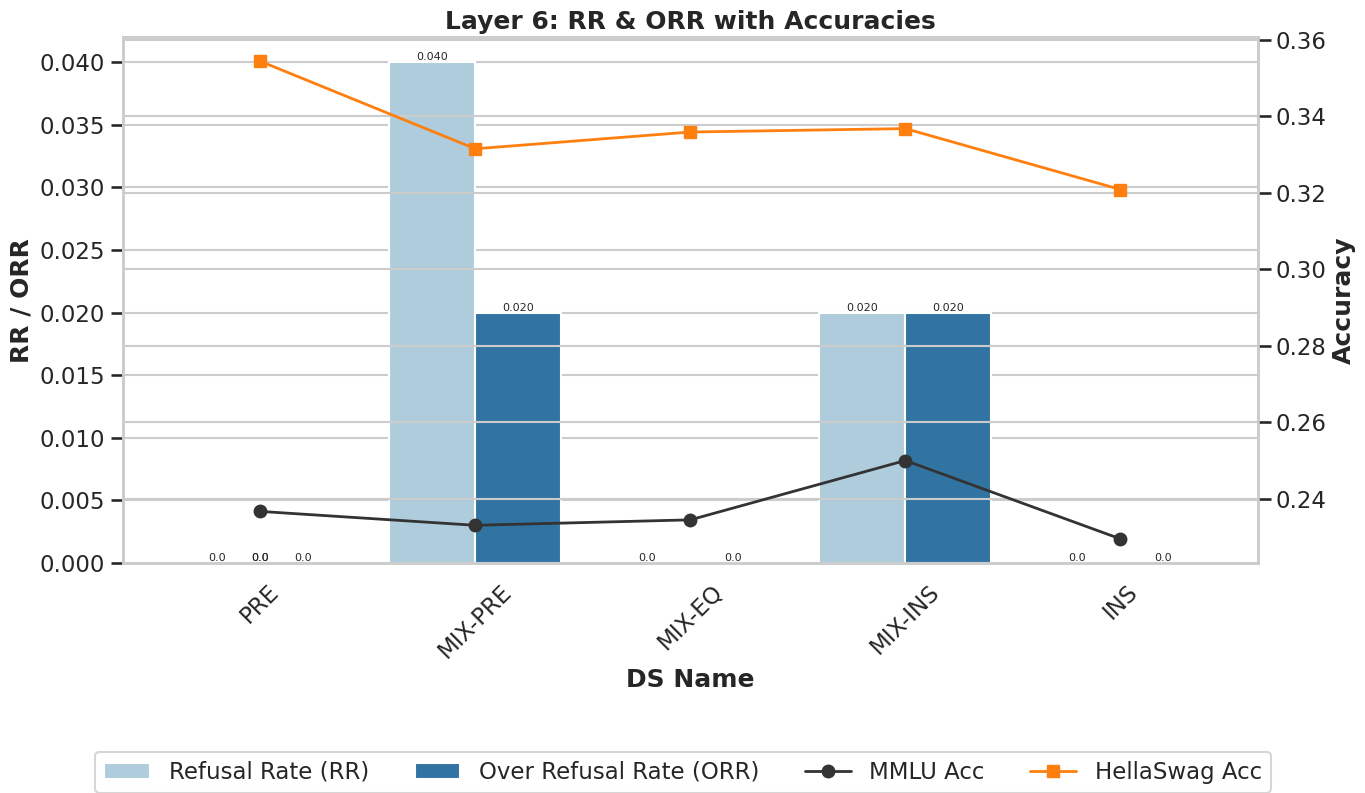

-> saved to results/visualizations/layer_6_rr_orr_acc.png


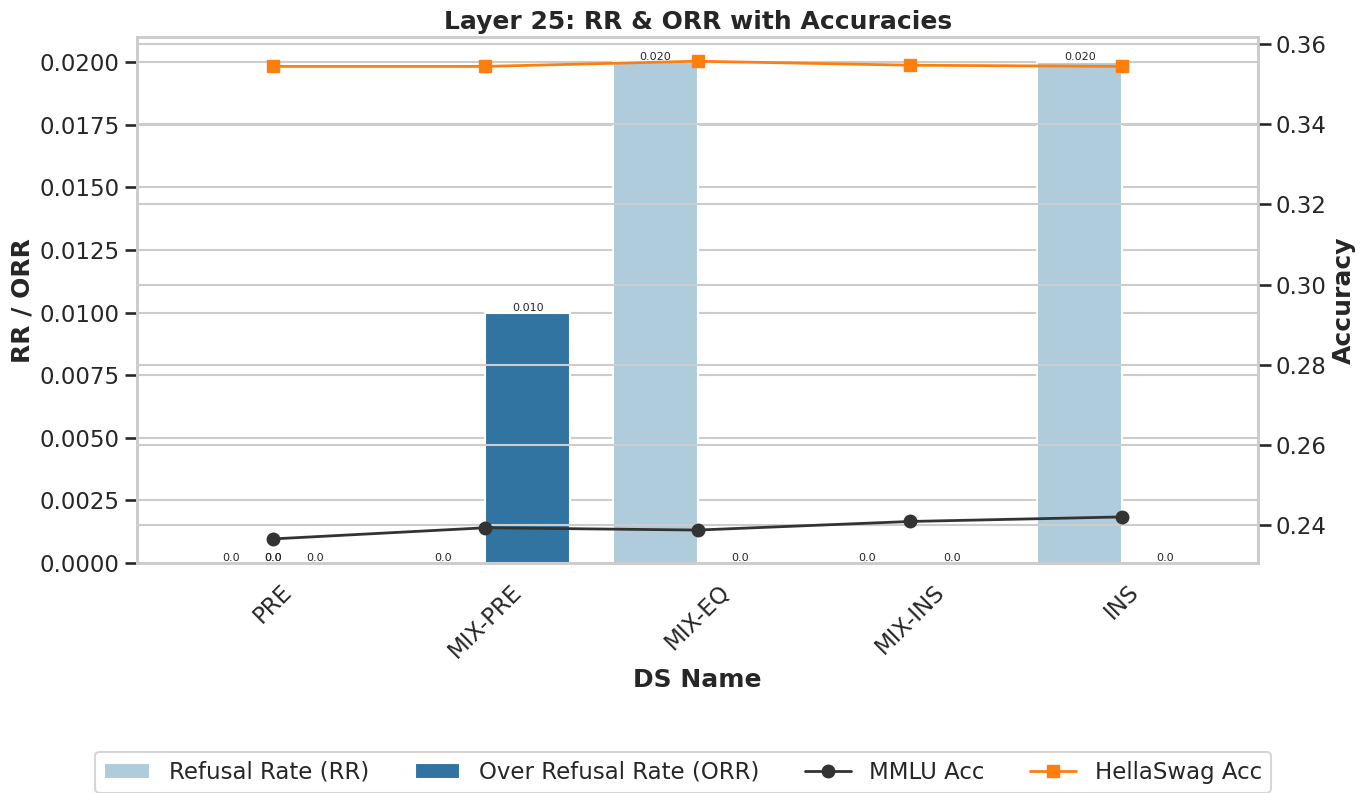

-> saved to results/visualizations/layer_25_rr_orr_acc.png


In [37]:
def plot_sae_perf(merged_df: pd.DataFrame,
                  results_path: str = "results/visualizations",
                  filename_template: str = "layer_{layer}_rr_orr_acc.png"):
    """
    For each layer, draw RR & ORR bars (with 'PRE' baseline)
    and overlay MMLU & HellaSwag accuracy lines.

    X-axis order fixed to: PRE, MIX-PRE, MIX-EQ, MIX-INS, INS.
    Single legend outside, zeros labeled '0.0'.
    """
    Path(results_path).mkdir(parents=True, exist_ok=True)
    layers = sorted(merged_df['layer'].unique())
    # desired x-axis order
    desired_order = ['PRE', 'MIX-PRE', 'MIX-EQ', 'MIX-INS', 'INS']

    # compute PRE baseline if present
    pre_df = merged_df[merged_df['ds_name'] == 'PRE']
    pre_stats = pre_df[['rr','orr','mmlu_acc','hellaswag_acc']].mean() if not pre_df.empty else None

    # rename mapping for bar metrics
    rename_map = {'rr': 'Refusal Rate (RR)', 'orr': 'Over Refusal Rate (ORR)'}

    for layer in layers:
        df_layer = merged_df[merged_df['layer'] == layer].copy()

        # assemble df_plot with baseline
        if pre_stats is not None:
            no_pre = df_layer[df_layer['ds_name'] != 'PRE']
            pre_row = pd.DataFrame({
                'ds_name': ['PRE'],
                'rr': [pre_stats['rr']],
                'orr': [pre_stats['orr']],
                'mmlu_acc': [pre_stats['mmlu_acc']],
                'hellaswag_acc': [pre_stats['hellaswag_acc']]
            })
            df_plot = pd.concat([pre_row, no_pre], ignore_index=True)
        else:
            df_plot = df_layer[['ds_name','rr','orr','mmlu_acc','hellaswag_acc']].copy()

        # reindex to desired order, drop rows not present
        df_plot = (df_plot
                   .set_index('ds_name')
                   .reindex(desired_order)
                   .dropna(subset=['rr','orr'], how='all')
                   .reset_index())

        # melt for barplot
        df_long = df_plot.melt(
            id_vars='ds_name', value_vars=['rr','orr'],
            var_name='metric', value_name='value'
        )
        df_long['metric'] = df_long['metric'].map(rename_map)

        sns.set_theme(style="whitegrid", context="talk")
        fig, ax1 = plt.subplots(figsize=(14,8))

        # barplot with fixed order
        sns.barplot(
            data=df_long,
            x='ds_name', y='value', hue='metric',
            order=desired_order,
            palette='Paired', ax=ax1
        )
        # remove internal legend
        if ax1.legend_:
            ax1.legend_.remove()

        # annotate bars
        for bar in ax1.patches:
            h = bar.get_height()
            lbl = '0.0' if h == 0 else f"{h:.3f}"
            ax1.annotate(lbl,
                         xy=(bar.get_x()+bar.get_width()/2, h),
                         ha='center', va='bottom', fontsize=8)

        ax1.set_xlabel("DS Name", weight='bold')
        ax1.set_ylabel("RR / ORR", weight='bold')
        ax1.set_title(f"Layer {layer}: RR & ORR with Accuracies", weight='bold')
        ax1.tick_params(axis='x', rotation=45)

        # secondary axis for accuracies
        ax2 = ax1.twinx()
        x = np.arange(len(df_plot))
        ax2.plot(x, df_plot['mmlu_acc'], '-o', color='#333333', label='MMLU Acc', linewidth=2)
        ax2.plot(x, df_plot['hellaswag_acc'], '-s', color='#FF7F0E', label='HellaSwag Acc', linewidth=2)
        ax2.set_ylabel("Accuracy", weight='bold')

        # combined legend outside
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        handles = h1 + h2
        labels = l1 + l2
        fig.legend(handles, labels,
                   loc='lower center',
                   ncol=len(labels), borderaxespad=0.)

        plt.tight_layout(rect=[0, 0.08, 1, 1])
        save_path = Path(results_path)/filename_template.format(layer=layer)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"-> saved to {save_path}")


plot_sae_perf(merged_df)

## Report Gathering & Tables

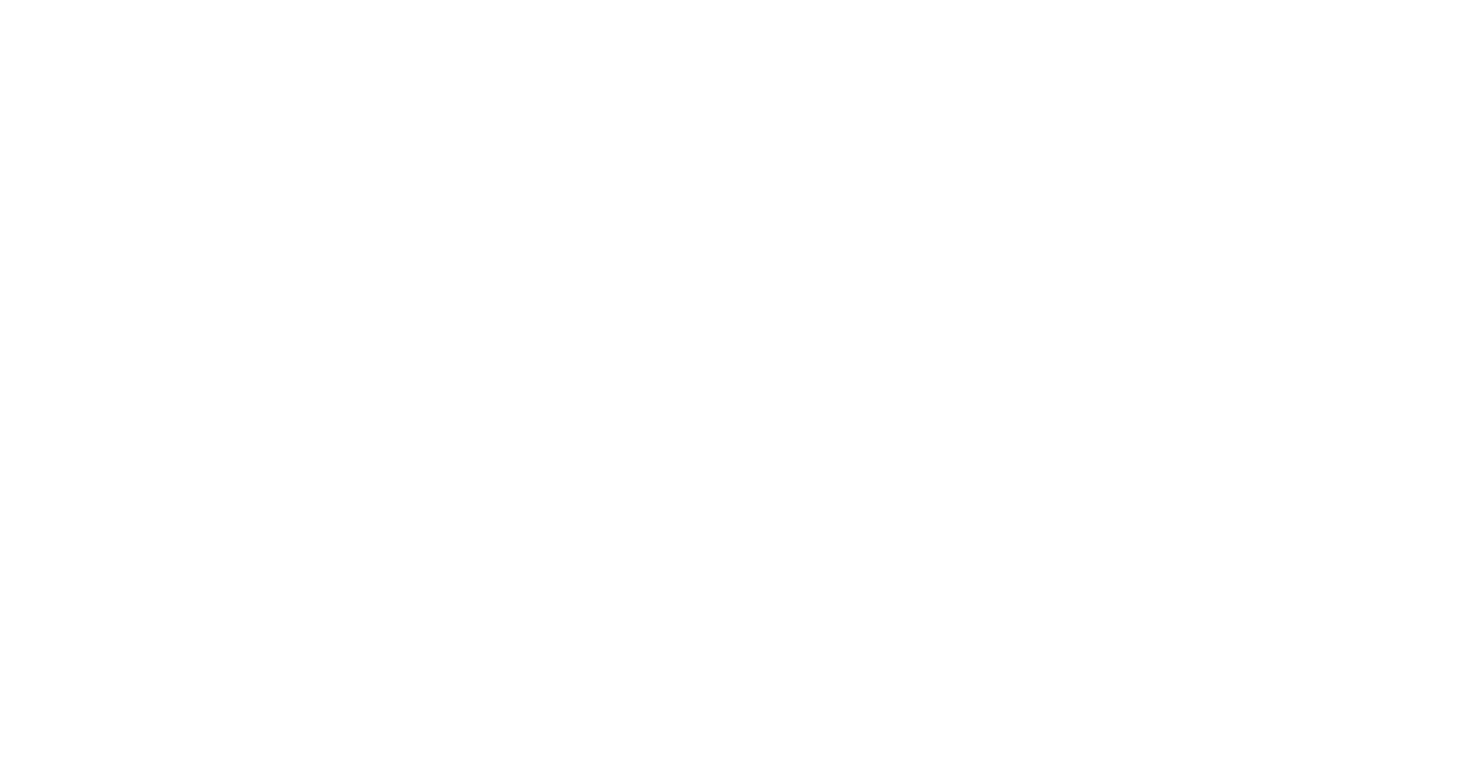

In [31]:
df_long, df_short, latex_long, latex_short, fig = fetch_and_report_wandb(
    "tilmankerl-technical-university-of-vienna/MA-sae-train/k867a0u3"
)

In [32]:
display(df_long)
display(df_short)

,Metric,Value
0,Explained Variance,-21.291372
1,Reconstruction MSE,112.596863
2,Cosine Similarity,0.905586
3,Overall Loss,487019.312500
4,MSE Loss,484256.343750
5,L1 Loss,5525.955078
6,Activation Sparsity (L0),4069.241943
7,L1 Sparsity (sum abs activ.),5526.010254
8,Dead Features,0.000000
9,Shrinkage (L2 Ratio),6.015663


,Metric,Value
0,Explained Variance,-21.291372
1,Reconstruction MSE,112.596863
2,Activation Sparsity (L0),4069.241943
3,L1 Sparsity,5526.010254
4,Overall Loss,487019.312500
5,CE Loss (no SAE),2.719747


In [33]:
print(latex_long)
print(latex_short)

\begin{table}
\caption{SAE Training results for \texttt{pythia-410m-deduped} on hook \texttt{blocks.10.hook_resid_post}, using the \texttt{lmsys-chat-1m-english-tokenized} dataset.}
\label{tab:sae_metrics_full}
\begin{tabular}{lr}
\toprule
Metric & Value \\
\midrule
Explained Variance & -21.2914 \\
Reconstruction MSE & 112.5969 \\
Cosine Similarity & 0.9056 \\
Overall Loss & 487019.3125 \\
MSE Loss & 484256.3438 \\
L1 Loss & 5525.9551 \\
Activation Sparsity (L0) & 4069.2419 \\
L1 Sparsity (sum abs activ.) & 5526.0103 \\
Dead Features & 0.0000 \\
Shrinkage (L2 Ratio) & 6.0157 \\
Relative Recon. Bias & 6.5952 \\
CE Loss (no SAE) & 2.7197 \\
CE Loss (with SAE) & 4.4576 \\
CE Loss (ablation) & 11.6825 \\
CE Loss Score & 0.8061 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{SAE Training results for \texttt{pythia-410m-deduped} on hook \texttt{blocks.10.hook_resid_post}, using the \texttt{lmsys-chat-1m-english-tokenized} dataset.}
\label{tab:sae_metrics_short}
\begin{tabula

In [34]:
all_epx_data = []

all_delphi_stats_paths = [
    pathlib.Path(f"./evaluation/results/EXP-{sae_name}/explanations/")
    for sae_name in all_delphi_saes
]

latent_pattern = re.compile(r"_latent(\d+)$")

for idx, delphi_stats_path in enumerate(all_delphi_stats_paths):
    if not delphi_stats_path.is_dir():
        raise FileNotFoundError(f"directory not found: {delphi_stats_path}")

    for txt_file in delphi_stats_path.glob("*.txt"):
        try:
            # read entire file as text
            content = txt_file.read_text(encoding="utf-8")
            # extract latent index
            m = latent_pattern.search(txt_file.stem)
            latent_idx = int(m.group(1)) if m else None
            all_epx_data.append({
                "filename": txt_file.name,
                "latent": latent_idx,
                "content": content,
                "sae": all_delphi_saes[idx]
            })
        except Exception as e:
            # catch any I/O or parsing errors
            print(f"error processing '{txt_file.name}': {e}")
    
    print(f"successfully loaded data from {len(all_epx_data)} txt files.")


successfully loaded data from 954 txt files.
successfully loaded data from 1812 txt files.
successfully loaded data from 2761 txt files.
successfully loaded data from 3602 txt files.
successfully loaded data from 4545 txt files.
successfully loaded data from 5389 txt files.
successfully loaded data from 6335 txt files.
successfully loaded data from 7168 txt files.


FileNotFoundError: directory not found: evaluation/results/EXP-sae-SmolLM2-135M-64x-layer-6/explanations

In [ ]:
exp_df = pd.DataFrame(all_epx_data)

## SAE-Train Visualisations

In [ ]:
from evaluation.visualise_sae_metrics import load_sae_results, visualize_sae_results_grouped, plot_data_dependence_heatmap

RESULTS_DIRECTORY = "results/saes/"

results_df = load_sae_results(RESULTS_DIRECTORY)
# if not results_df.empty:
    # visualize_sae_results_grouped(results_df)

In [ ]:
results_df.sort_values(by="mse", ascending=True)

**Pick best SAEs for every layer:**

In [ ]:
idx = (
    results_df
    .groupby(["layer", "sae_train_dataset"])["explained_variance"]
    .idxmax()
)
best_df = results_df.loc[idx].reset_index(drop=True)
best_saes_checkpoint_names = best_df["sae_checkpoint_name"].to_list()

In [ ]:
best_saes_checkpoint_names

In [ ]:
best_df

In [ ]:
results_df.to_csv("results/saes/aggregations/saes.csv", index=False)

In [ ]:
df_summary = results_df.groupby(["sae_train_dataset", "sae_expansion_factor", "eval_dataset"]).agg({
    "explained_variance": "mean",
    "dead_features_pct": "mean",
    "activation_sparsity_l0": "mean"
}).reset_index()

In [ ]:
metric_list = [
    "explained_variance",
    # "fraction_var_unexplained",
    "mse",
    "cosine_similarity",
    # "activation_sparsity_l0",
    # "weight_sparsity",
    # "dead_features_pct"
]

for metric in metric_list:
    print(f"--- Generating plot for {metric} ---")
    
    # Use a different colormap for metrics where "higher is worse" (like MSE)
    color_map = "Blues_r" if metric in ["mse", "fraction_var_unexplained"] else "Blues"
    
    # Use a different format for percentages
    num_format = ".2f" if "pct" in metric else ".4f"

    plot_data_dependence_heatmap(
        df=results_df,
        metric_name=metric,
        # results_path=results_path,
        cmap=color_map,
        fmt=num_format
    )

## Dataset-visuals

In [ ]:
sns.set_theme(style="whitegrid", context="talk")

results_dir = "results/dataset_chars"
data = []
for fname in os.listdir(results_dir):
    if fname.endswith("_metrics.json"):
        with open(os.path.join(results_dir, fname), "r") as f:
            d = json.load(f)
        d["dataset"] = fname.replace("_metrics.json", "")
        data.append(d)

df = pd.DataFrame(data)
df.set_index("dataset", inplace=True)

ordered_datasets = ["INS", "MIX-INS", "MIX-EQ", "MIX-PRE", "PRE"]

# Filter and reorder the dataframe accordingly
df_filtered = df.loc[df.index.intersection(ordered_datasets)]
df_ordered = df_filtered.reindex(ordered_datasets)

# Plot each metric separately using the ordered dataset list
metrics = ["context_length", "ngram_diversity", "compression_ratio", "refusal_rate", "type_token_ratio"]
n_metrics = len(metrics)

fig, axes = plt.subplots(nrows=1, ncols=n_metrics, figsize=(4 * n_metrics, 5), sharex=False)

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x=df_ordered.index, y=df_ordered[metric], ax=ax, palette="Blues_d")
    ax.set_title(metric.replace("_", " ").title(), fontsize=12)
    ax.set_ylabel("")  # suppress for compactness
    ax.set_xlabel("")

    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.suptitle("Dataset Characteristics by Metric", fontsize=16, y=1.05, weight="bold")
plt.tight_layout()
plt.savefig("./results/visualizations/dataset_chars.png", dpi=150, bbox_inches='tight')
plt.show()